# Cluster Model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns 
from matplotlib.patches import Circle
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import silhouette_score
from sklearn.feature_selection import VarianceThreshold
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance



In [2]:
# Read csv files
df = pd.read_csv(r"./assets/general_corr.csv")
df = df.drop(['Unnamed: 0'], axis=1)
df2 = pd.read_csv(r"./assets/ratios.csv", low_memory=False)
df2 = df2.drop(['Unnamed: 0'], axis=1)
# Join files
new_df = pd.merge(df, df2, on='zone_id')

In [3]:
new_df.columns

Index(['zone_id', 'Quartier', 'shop', 'Corr_Somme par jour_rain',
       'Corr_Somme par jour_temperaturefeelslike',
       'Corr_Somme par jour_windspeed', 'Corr_Somme par jour_humidity',
       'Corr_Weekday_Somme par jour_temperaturefeelslike',
       'Corr_Somme par jour_pressure', 'Corr_Somme par jour_visibility',
       'part_1', 'part_2', 'part_3', 'part_1_relat', 'part_2_relat',
       'part_3_relat', 'avg_visits_perSensor_school', 'avg_visits_perSensor',
       'ratio_school', 'avg_visits_perSensor_public', 'ratio_public',
       'avg_Monday', 'avg_Tuesday', 'avg_Wednesday', 'avg_Thursday',
       'avg_Friday', 'avg_Saturday', 'avg_Sunday', 'avg_avg_weekday',
       'ratio_Saturday', 'ratio_Sunday', 'avg_Monday_relat',
       'avg_Tuesday_relat', 'avg_Wednesday_relat', 'avg_Thursday_relat',
       'avg_Friday_relat', 'avg_Saturday_relat', 'avg_Sunday_relat',
       'cv_Monday', 'cv_Tuesday', 'cv_Wednesday', 'cv_Thursday', 'cv_Friday',
       'cv_Saturday', 'cv_Sunday', 'cv_wee

In [4]:
# DataFrame without Morolles: 10151, Helmet: 10175, Luxemburg: 13487, Congres: 13485, Tongres: 10178, La Bascule: 10198
new_df = new_df[ (new_df['zone_id'] != 10151) & (new_df['zone_id'] != 10175) 
        & (new_df['zone_id'] != 13487) & (new_df['zone_id'] != 13485) & (new_df['zone_id'] != 10178)
        & (new_df['zone_id'] != 10198)] 
new_df.reset_index(drop=True, inplace=True) # (new_df['zone_id'] != 10151) &
new_df['zone_id'].value_counts().count()

46

##  Variance Threshold Analysis

In [5]:
# Select variables
train = new_df.iloc[:,3:-3]
var_thr = VarianceThreshold(threshold = 0.5) 
var_thr.fit(train)
var_thr.get_support()
# Show the variables out of the threshold
var_thr.get_feature_names_out()  

array(['part_1', 'part_2', 'part_3', 'avg_visits_perSensor_school',
       'avg_visits_perSensor', 'avg_visits_perSensor_public',
       'avg_Monday', 'avg_Tuesday', 'avg_Wednesday', 'avg_Thursday',
       'avg_Friday', 'avg_Saturday', 'avg_Sunday', 'avg_avg_weekday'],
      dtype=object)

In [6]:
# Variables for app
var_thres = [column for column in train.columns 
          if column not in train.columns[var_thr.get_support()]]
# DataFrame 
outcol = [column for column in train.columns 
          if column in train.columns[var_thr.get_support()]]
train = train.drop(outcol,axis=1)
train.shape

(46, 30)

In [7]:
from sklearn.feature_selection import VarianceThreshold

train2 = train.copy()
try:
    var_thr = VarianceThreshold(threshold=.05)
    var_thr.fit(train2)
    var_thr.get_support()

except ValueError:
    print("No feature is strong enough to keep")
    var_thr = []

In [8]:
col = [column for column in train2.columns 
          if column not in train2.columns[var_thr.get_support()]]
train2 = train2.drop(col,axis=1)
train2.columns

Index(['Corr_Weekday_Somme par jour_temperaturefeelslike', 'ratio_public',
       'ratio_Sunday', 'cv_Sunday'],
      dtype='object')

In [9]:
train2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 4 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Corr_Weekday_Somme par jour_temperaturefeelslike  46 non-null     float64
 1   ratio_public                                      43 non-null     float64
 2   ratio_Sunday                                      46 non-null     float64
 3   cv_Sunday                                         46 non-null     float64
dtypes: float64(4)
memory usage: 1.6 KB


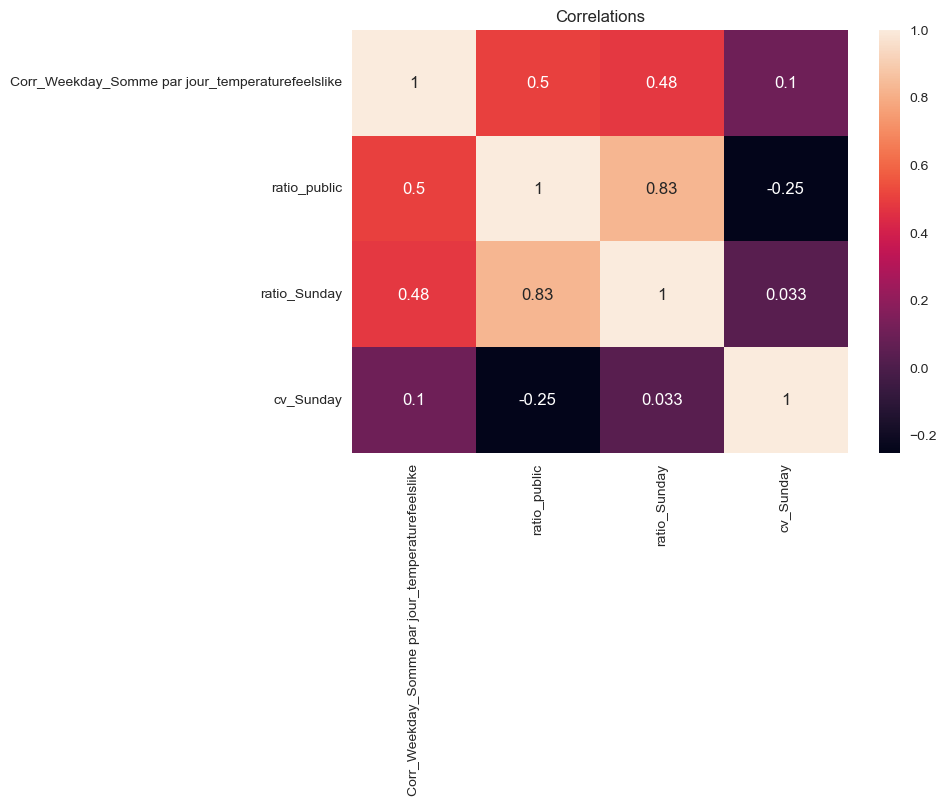

In [10]:
# Correlation matrix 
corrMatrix = train2.corr()  
ax = sns.heatmap(corrMatrix, annot=True)
ax.set_title('Correlations');

In [11]:
# Variables selection, mixed automatically and manually
new_df = new_df[['zone_id', 'Quartier', 'shop', 'startdate', 
        'Corr_Somme par jour_temperaturefeelslike',
        'ratio_Saturday', 
        'ratio_school',
        'cv_Sunday']]

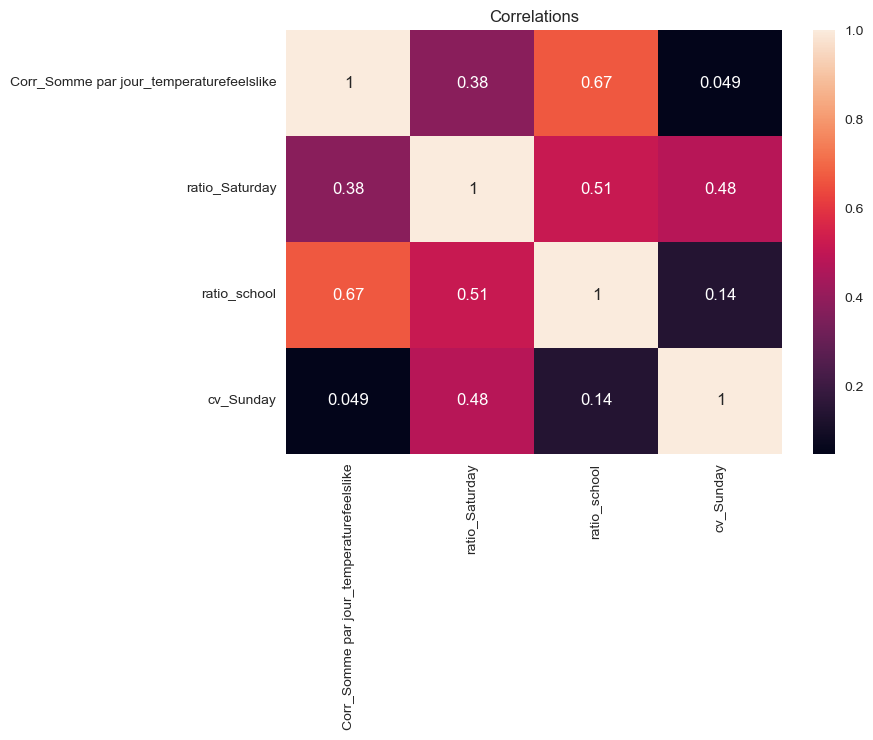

In [12]:
# Correlation matrix - variables selection
corrMatrix = new_df.iloc[:,4:].corr()  
ax = sns.heatmap(corrMatrix, annot=True)
ax.set_title('Correlations');

In [13]:
# Check for NaN under an entire DataFrame:
new_df.isnull().values.any()

True

In [14]:
#  Count the NaN under an entire DataFrame
new_df.isnull().sum().sum()

1

In [15]:
# Drop Rows with NaN Values inplace
new_df.dropna(inplace=True)
new_df.shape

(45, 8)

Select features

In [16]:
#Select features
X = new_df.iloc[:,4:].values
X.shape

(45, 4)

In [17]:
Y = new_df.iloc[:,:1].values
Y.shape

(45, 1)

## PCA - Explained variance

In [18]:
import plotly.express as px

pca = PCA()
pca.fit(X) 
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

fig=px.area(
    x=range(1,  exp_var_cumul.shape[0] + 1), 
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"}, 
)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='crimson', ticklen=10)
fig.update_xaxes(tick0=1, dtick=1)
fig.show()

In [19]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)  
pca_newdf = pd.DataFrame(data = principalComponents
             , columns = ['principal_component1', 'principal_component2',  ])  #  'principal_component3'


# PCA correlation circle

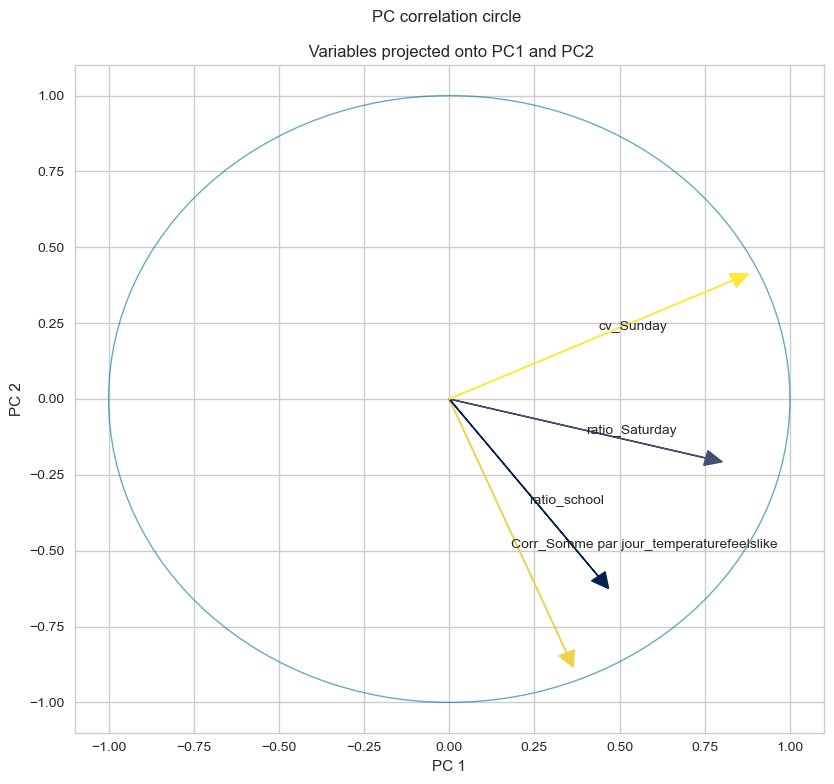

In [20]:
ccircle = []
eucl_dist = []
for i,j in enumerate(X .T):
    corr1 = np.corrcoef(j,principalComponents[:,0])[0,1]
    corr2 = np.corrcoef(j,principalComponents[:,1])[0,1]
    ccircle.append((corr1, corr2))
    eucl_dist.append(np.sqrt(corr1**2 + corr2**2))


with plt.style.context(('seaborn-whitegrid')):
    fig, axs = plt.subplots(figsize=(8.5, 8))
    for i,j in enumerate(eucl_dist):
        arrow_col = plt.cm.cividis((eucl_dist[i] - np.array(eucl_dist).min())/\
                                (np.array(eucl_dist).max() - np.array(eucl_dist).min()) )
        axs.arrow(0,0, # Arrows start at the origin
                 ccircle[i][0],  #0 for PC1
                 ccircle[i][1],  #1 for PC2
                 lw = 1, # line width
                 length_includes_head=True, 
                 color = arrow_col,
                 fc = arrow_col,
                 head_width=0.05,
                 head_length=0.05)


        axs.text(ccircle[i][0]/2,ccircle[i][1]/1.8, new_df.columns[4:][i], fontsize=10)   #iris.feature_names
        
    # Draw the unit circle, for clarity
    circle = Circle((0, 0), 1, facecolor='none', edgecolor='b', linewidth=1, alpha=0.6)
    axs.add_patch(circle)
    axs.set_xlabel("PC 1")
    axs.set_ylabel("PC 2")
    axs.set_title("PC correlation circle \n \n Variables projected onto PC1 and PC2")
plt.tight_layout()
plt.show()

## Elbow visualizer

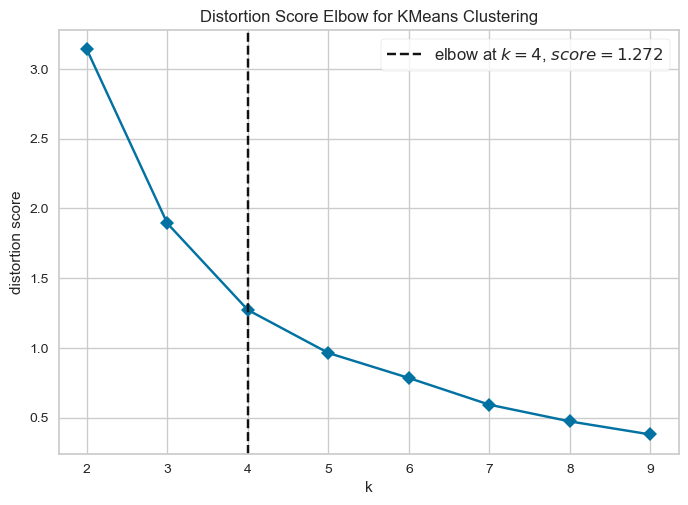

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [21]:
#from sklearn import datasets
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer   #SilhouetteVisualizer

# Instantiate the clustering model and visualizer
km = KMeans(random_state=42)
visualizer = KElbowVisualizer(km, k=(2,10), timings=False)

# Fit the data to the visualizer
visualizer.fit(pca_newdf)  
# Finalize and render the figure      
visualizer.show()        

In [22]:
import sklearn.cluster as cluster
import sklearn.metrics as metrics

for i in range(2,12):
    labels=cluster.KMeans(n_clusters=i,random_state=200).fit(pca_newdf).labels_
    print ("Silhouette score for k clusters = "+str(i)+" is "
           +str(metrics.silhouette_score(pca_newdf,labels,metric="euclidean",sample_size=1000,random_state=200)))


Silhouette score for k clusters = 2 is 0.38223299824019746
Silhouette score for k clusters = 3 is 0.4312968479580917
Silhouette score for k clusters = 4 is 0.4012644359517174
Silhouette score for k clusters = 5 is 0.4307993145379917
Silhouette score for k clusters = 6 is 0.43111820077906904
Silhouette score for k clusters = 7 is 0.4197951831372146
Silhouette score for k clusters = 8 is 0.42245831131176853
Silhouette score for k clusters = 9 is 0.4377106129852297
Silhouette score for k clusters = 10 is 0.43377827627110105
Silhouette score for k clusters = 11 is 0.4547416961960511


In [23]:
import plotly.express as px
import sklearn.cluster as cluster
import sklearn.metrics as metrics

silhouette_avg = []
for i in range(2,11):
    labels=cluster.KMeans(n_clusters=i,random_state=200).fit(pca_newdf).labels_
    silhouette_avg.append(metrics.silhouette_score(pca_newdf, labels ,metric="euclidean",sample_size=1000,random_state=200))

round_silhouette_avg = [round(num, 6) for num in silhouette_avg]
fig = px.line(x=range(2,11), y=silhouette_avg, title='Silhouette analysis for Optimal k', markers=True, labels={
    'x':'Values of K',
    'y':'Silhouette score'
}, text=round_silhouette_avg)  

fig.update_traces(textposition='top center')
fig.show()  

## K-Means Cluster

In [24]:
# K-Means Cluster
k = 6
kmeans = cluster.KMeans(n_clusters=k, random_state=0)
kmeans = kmeans.fit(pca_newdf)

In [25]:
# Calculate Silhoutte Score
score = silhouette_score(pca_newdf, kmeans.labels_, metric='euclidean')
print('Silhouette Score: %.3f' % score)

Silhouette Score: 0.431


In [26]:
# Add variables to the dataFrame 
pca_newdf['Cluster'] = kmeans.labels_
#add zone
pca_newdf['zone_id'] = Y
# Join dataFrames 
zones = pd.read_csv('./assets/zones_modif.csv')
pca_newdf = pd.merge(pca_newdf, zones[['zone_id', 'Quartier', 'shop']], on='zone_id', how='left')

Plot K-Means 6 Clusters

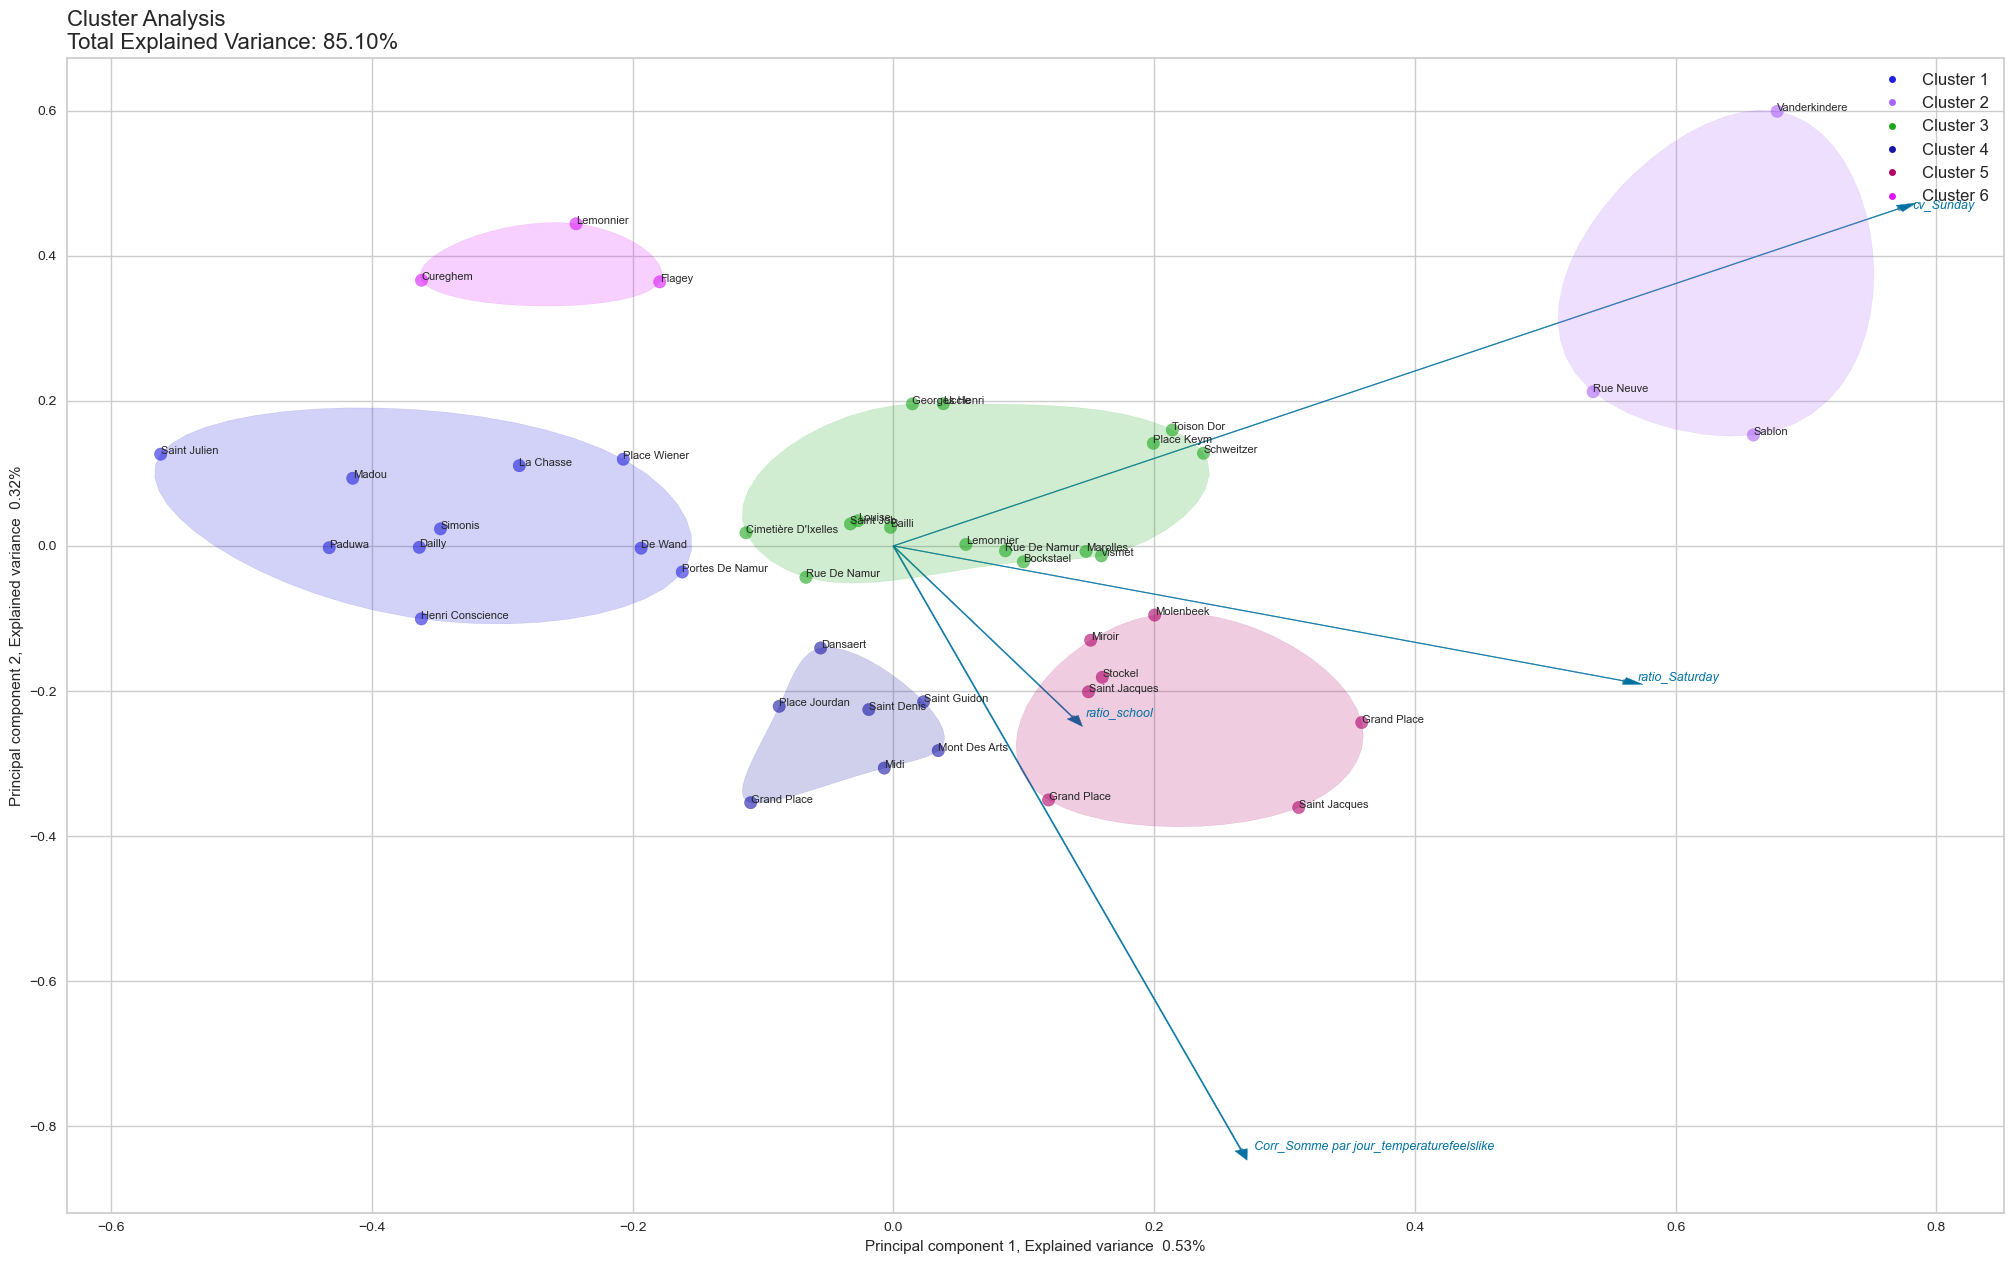

In [27]:
from matplotlib.pyplot import figure
from scipy import interpolate
from scipy.spatial import ConvexHull

figure(figsize=(25, 15),dpi=100)  

#define and map colors
colors = ['#2020DF', '#AB63FA', '#1CA71C', '#1616A7','#B00068', '#DA16FF']  
pca_newdf['c'] = pca_newdf.Cluster.map({0:colors[0], 1:colors[1], 2:colors[2], 3:colors[3], 4:colors[4],  5:colors[5]})#

# plot data
from matplotlib.lines import Line2D
plt.scatter(pca_newdf.principal_component1, pca_newdf.principal_component2, color=pca_newdf.Cluster.apply(lambda x: colors[x]), alpha = 0.6, s=80)  #c=pca_newdf.c
#ax.grid(True)


# Define the x, y, z variables
loadings = pca.components_
xs = loadings[0]
ys = loadings[1]

# Plot the loadings
for i, varnames in enumerate(new_df.columns[4:]):
    plt.scatter(xs[i], ys[i], s=10, alpha=.7, color='grey')  
    # Plot the arrows
    plt.arrow(
        0, 0, # coordinates of arrow base
        xs[i], # length of the arrow along x
        ys[i], # length of the arrow along y
        color='b', 
        head_width=0.01
        )
    plt.text(xs[i]+0.01 , ys[i], varnames, fontsize=9, style= 'italic', color='b')

for i in pca_newdf.Cluster.unique():
    # get the convex hull
    points = pca_newdf[pca_newdf.Cluster == i][['principal_component1', 'principal_component2']].values
    hull = ConvexHull(points)
    x_hull = np.append(points[hull.vertices,0],
                       points[hull.vertices,0][0])
    y_hull = np.append(points[hull.vertices,1],
                       points[hull.vertices,1][0])
    # interpolate
    dist = np.sqrt((x_hull[:-1] - x_hull[1:])**2 + (y_hull[:-1] - y_hull[1:])**2)
    dist_along = np.concatenate(([0], dist.cumsum()))
    spline, u = interpolate.splprep([x_hull, y_hull], 
                                    u=dist_along, s=0, per=1)
    interp_d = np.linspace(dist_along[0], dist_along[-1], 50)
    interp_x, interp_y = interpolate.splev(interp_d, spline)
    # plot shape
    plt.fill(interp_x, interp_y, '--', c=colors[i], alpha=0.2)

# Create a list of legend elements
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Cluster {}'.format(i+1), markerfacecolor=mcolor, markersize=5) for i, mcolor in enumerate(colors)]

# plot legend
plt.legend(handles=legend_elements, loc='upper right', fontsize=12)

# title and labels
plt.title(f'Cluster Analysis \nTotal Explained Variance: {pca.explained_variance_ratio_.sum()*100:.2f}%', loc='left', fontsize=16)
plt.xlabel(f'Principal component 1, Explained variance  {pca.explained_variance_ratio_[0]:.2f}%')
plt.ylabel(f'Principal component 2, Explained variance  {pca.explained_variance_ratio_[1]:.2f}%')

for i in range(pca_newdf.shape[0]):
    plt.text(x=pca_newdf.principal_component1[i],y=pca_newdf.principal_component2[i],s=pca_newdf.Quartier[i], fontsize=8)
plt.savefig("./assets/cluster_area.png")